In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import sys

**Dataset URL -**

https://www.kaggle.com/datasets/anshtanwar/jellyfish-types

In [2]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    # Change path below starting from /content/drive/MyDrive/Colab Notebooks/
    # depending on how data is organized inside your Colab Notebooks folder in
    # Google Drive
    DIR = '/content/drive/MyDrive/'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


In [3]:
import zipfile

# Specify the path to the uploaded zip file
zip_file_path = "/content/drive/MyDrive/Dataset_For_DL/archive (1).zip"  # Replace with the actual path

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/extracted_dataset")  # Specify the extraction directory


In [4]:
import os
import shutil

# Source directory containing all folders
source_dir = "/content/extracted_dataset"

# Destination directory where folders will be copied
destination_dir = "/content/jelly_fish"

# List of folders to exclude from copying
exclude_folders = ["Train_Test_Valid"]

# Get a list of all folders in the source directory
all_folders = [folder for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder))]

# Filter out folders to exclude
folders_to_copy = [folder for folder in all_folders if folder not in exclude_folders]

# Copy each folder to the destination directory
for folder in folders_to_copy:
    source_folder = os.path.join(source_dir, folder)
    destination_folder = os.path.join(destination_dir, folder)
    shutil.copytree(source_folder, destination_folder)

print("Folders copied successfully.")


Folders copied successfully.


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
data_dir = '/content/jelly_fish'

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 6 classes.
Using 720 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 6 classes.
Using 180 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


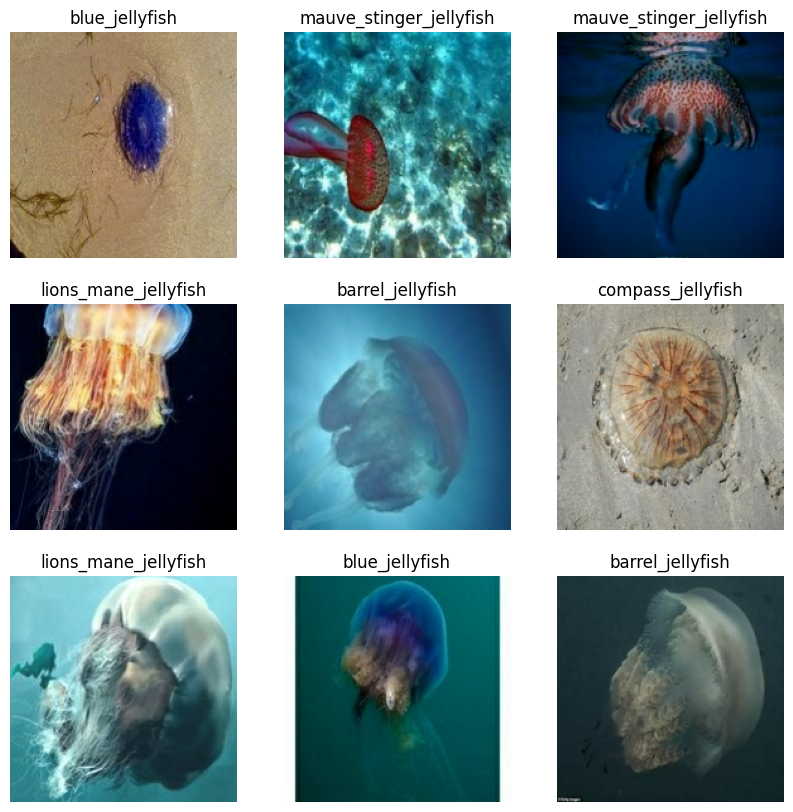

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.931723


In [15]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(class_names)

# Define the input shape based on img_height and img_width
# img_height = 180
# img_width = 180
input_shape = (img_height, img_width, 3)

# Define the input layer with the specified shape
inputs = tf.keras.Input(shape=input_shape)

# Preprocessing layer: Rescaling
x = layers.Rescaling(1./255)(inputs)

# Convolutional layers
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Flatten layer
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(128, activation='relu')(x)

# Output layer
outputs = layers.Dense(num_classes)(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                        

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                        

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
23/23 [==============================] - 32s 1s/step - loss: 1.7208 - accuracy: 0.2306 - val_loss: 1.5384 - val_accuracy: 0.3611
Epoch 2/10
23/23 [==============================] - 28s 1s/step - loss: 1.3920 - accuracy: 0.4264 - val_loss: 1.3235 - val_accuracy: 0.4889
Epoch 3/10
23/23 [==============================] - 38s 2s/step - loss: 1.1900 - accuracy: 0.5417 - val_loss: 1.2761 - val_accuracy: 0.4611
Epoch 4/10
23/23 [==============================] - 32s 1s/step - loss: 0.9293 - accuracy: 0.6264 - val_loss: 1.1163 - val_accuracy: 0.5444
Epoch 5/10
23/23 [==============================] - 31s 1s/step - loss: 0.6983 - accuracy: 0.7347 - val_loss: 1.1139 - val_accuracy: 0.6111
Epoch 6/10
23/23 [==============================] - 29s 1s/step - loss: 0.5596 - accuracy: 0.7972 - val_loss: 1.2533 - val_accuracy: 0.5889
Epoch 7/10
23/23 [==============================] - 31s 1s/step - loss: 0.4446 - accuracy: 0.8431 - val_loss: 1.1026 - val_accuracy: 0.6222
Epoch 8/10
23/23 [==

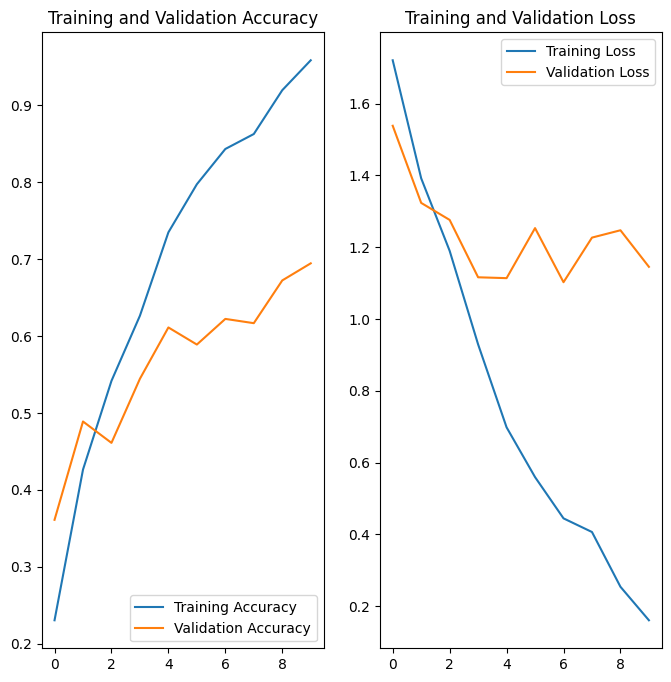

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Data augmentation layers
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# Create a model using the input and output layers
data_augmentation_model = tf.keras.Model(inputs=inputs, outputs=x)

# Display the model summary
data_augmentation_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


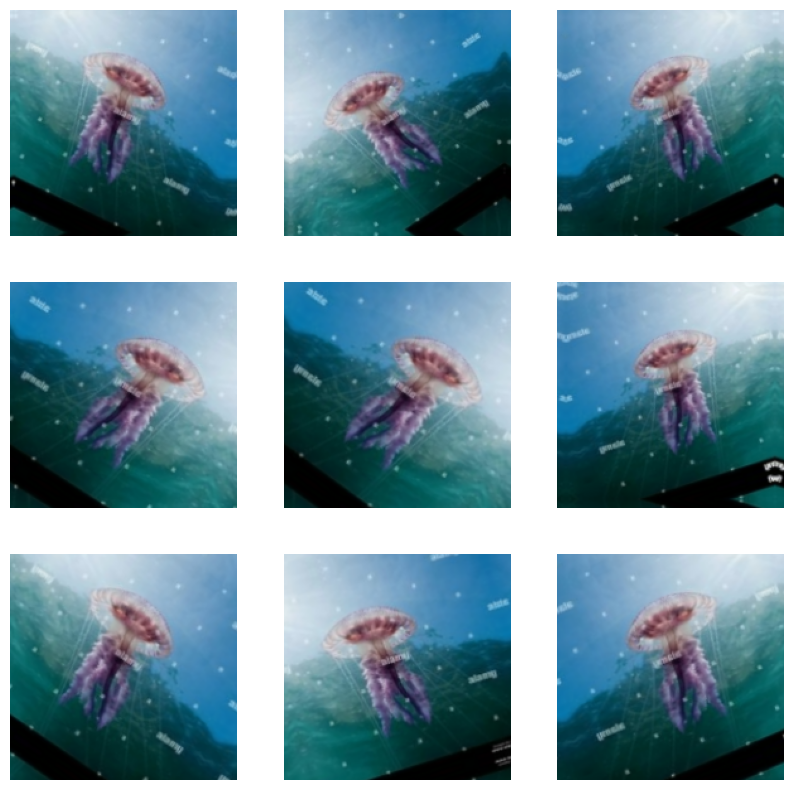

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation_model(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Data augmentation layers
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

x = layers.Rescaling(1./255)(x)

# Convolutional layers
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Dropout layer
x = layers.Dropout(0.2)(x)

# Flatten layer
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(128, activation='relu')(x)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax', name="outputs")(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                           

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                           

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


23/23 [==============================] - 30s 1s/step - loss: 1.6472 - accuracy: 0.3014 - val_loss: 1.4776 - val_accuracy: 0.3556
Epoch 2/15
23/23 [==============================] - 28s 1s/step - loss: 1.3478 - accuracy: 0.4736 - val_loss: 1.2466 - val_accuracy: 0.4556
Epoch 3/15
23/23 [==============================] - 28s 1s/step - loss: 1.2139 - accuracy: 0.5361 - val_loss: 1.1623 - val_accuracy: 0.4833
Epoch 4/15
23/23 [==============================] - 29s 1s/step - loss: 1.0884 - accuracy: 0.5931 - val_loss: 1.1741 - val_accuracy: 0.4778
Epoch 5/15
23/23 [==============================] - 31s 1s/step - loss: 1.0114 - accuracy: 0.6194 - val_loss: 1.1852 - val_accuracy: 0.5889
Epoch 6/15
23/23 [==============================] - 34s 2s/step - loss: 0.9400 - accuracy: 0.6403 - val_loss: 1.0265 - val_accuracy: 0.5944
Epoch 7/15
23/23 [==============================] - 28s 1s/step - loss: 0.9232 - accuracy: 0.6472 - val_loss: 1.0899 - val_accuracy: 0.5722
Epoch 8/15
23/23 [=============

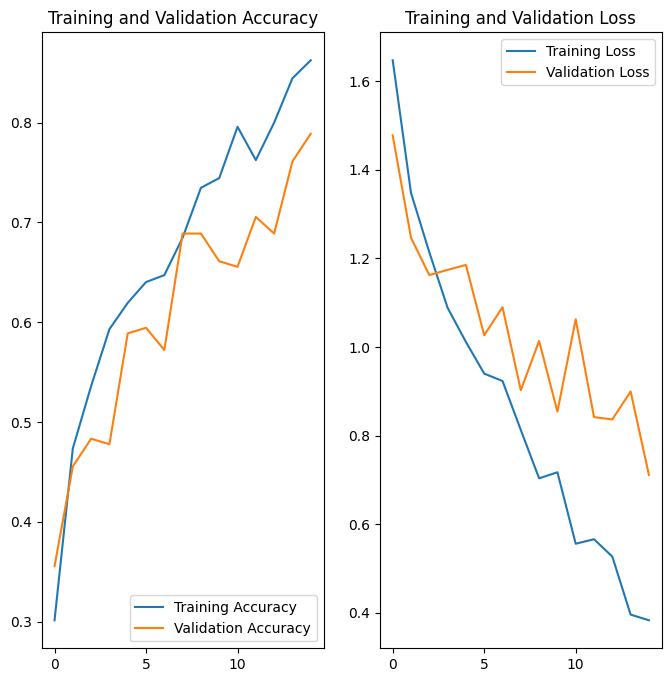

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
jellyfish_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR213KcL6vey6zvJOn0YvsF6LU0xdBVZMa3nA&s"
jellyfish_path = tf.keras.utils.get_file('Red_jellyfish', origin=jellyfish_url)

img = tf.keras.utils.load_img(
    jellyfish_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 162ms/step
This image most likely belongs to compass_jellyfish with a 31.47 percent confidence.
